# Preserving isosurfaces with safeguards

In this example, we compute the isosurface from a 3D dataset of wind `u` and pressure anomaly `p` during the 2003 hurricane Isabel. We compare how three different lossy compressors (ZFP, SZ3, and SPERR) affect the isosurface. Finally, we apply safeguards to guarantee that the isosurface of interest is preserved. We also showcase how the safeguards can be used to preserve an arbitrary number of isosurfaces.

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import numpy as np
from matplotlib import gridspec
from matplotlib import pyplot as plt

In [3]:
# Retrieve the data,
#  which is stored as a big endian float32 block of shape z*y*x = 100*500*500

pf48 = (
    np.fromfile(
        Path() / "data" / "isabel" / "Pf48.bin",
        dtype=">f4",
        count=500 * 500 * 100,
        sep="",
    )
    .reshape(100, 500, 500)
    .astype(np.float32)
)
pf48[pf48 == 1.0e35] = np.nan

uf48 = (
    np.fromfile(
        Path() / "data" / "isabel" / "Uf48.bin",
        dtype=">f4",
        count=500 * 500 * 100,
        sep="",
    )
    .reshape(100, 500, 500)
    .astype(np.float32)
)
uf48[uf48 == 1.0e35] = np.nan

In [4]:
def compute_corrections_percentage(my_f: np.ndarray, f: np.ndarray) -> float:
    return np.mean(~((my_f == f) | (np.isnan(my_f) & np.isnan(f))))

In [5]:
from numpy.lib.stride_tricks import sliding_window_view


def compute_failures(x, xnew, level):
    cells_x = sliding_window_view(x < level, (2, 2, 2))[::2, ::2, ::2].reshape(
        tuple(np.array(x.shape) // 2) + (2 * 2 * 2,)
    )
    cells_xnew = sliding_window_view(xnew < level, (2, 2, 2))[::2, ::2, ::2].reshape(
        tuple(np.array(x.shape) // 2) + (2 * 2 * 2,)
    )

    all_x = np.logical_and.reduce(cells_x, axis=-1)
    any_x = np.logical_or.reduce(cells_x, axis=-1)
    any_xnew = np.logical_or.reduce(cells_xnew, axis=-1)

    iso_x = any_x & ~all_x
    neq = np.logical_or.reduce(cells_x != cells_xnew, axis=-1)

    fn = any_x & ~any_xnew
    fp = ~any_x & any_xnew
    fs = any_x & any_xnew & neq

    return iso_x, fn, fp, fs

In [6]:
from skimage.measure import marching_cubes


def plot_isosurface(
    my_f,
    f,
    cr,
    ax,
    title,
    var,
    label,
    level,
    my_span,
    span,
    my_n=22,
    n=15,
    error=False,
    corr=None,
):
    with np.errstate(invalid="ignore"):
        err_inf = np.nanmax(np.abs(my_f - f))
        err_2 = np.sqrt(np.nanmean(np.square(my_f - f)))

    isof, fnv, fpv, fsv = compute_failures(f, my_f, level)
    ison = int(np.sum(isof))
    fn = int(np.sum(fnv)) / ison
    fp = int(np.sum(fpv)) / ison
    fs = int(np.sum(fsv)) / ison
    err_v = np.mean(((my_f < level) != (f < level)) | (np.isnan(my_f) != np.isnan(f)))

    ax.set_xlim(0, 500)
    ax.set_ylim(0, 500)
    ax.set_zlim(0, 100)

    ax.set_xticks(np.arange(0, 501, 500 / 3))
    ax.set_xticks(np.arange(0, 501, 500 / 6), minor=True)
    ax.set_xticklabels(
        [rf"${x}\degree$W" for x in np.linspace(83, 62, 4)], color="#777"
    )
    ax.set_yticks(np.arange(0, 501, 500 / 3)[:-1])
    ax.set_yticks(np.arange(0, 501, 500 / 6), minor=True)
    ax.set_yticklabels(
        [rf"${y}\degree$N" for y in np.linspace(23.7, 41.7, 4)[:-1]],
        color="#777",
        va="bottom",
        ha="left",
    )
    ax.set_zticks(np.arange(0, 101, 100 / 3))
    ax.set_zticks(np.arange(0, 101, 100 / 6), minor=True)
    ax.set_zticklabels(
        [f"${z}$km" for z in np.round(np.linspace(0.035, 19.835, 4), 3)],
        color="#777",
        ha="left",
    )

    levels = np.linspace(-span, span + 1, n)
    err_levels = np.linspace(-my_span, my_span, my_n)

    cb_f = (
        np.where(
            np.isnan(my_f) != np.isnan(f),
            np.nan_to_num(my_f) - np.nan_to_num(f),
            my_f - f,
        )
        if error
        else f
    )
    ct = my_span if error else span
    cb_b = 22 if error else 15

    extend_left = np.nanmin(cb_f) < -ct
    extend_right = np.nanmax(cb_f) > ct

    extend = {
        (False, False): "neither",
        (True, False): "min",
        (False, True): "max",
        (True, True): "both",
    }[(extend_left, extend_right)]

    x = np.broadcast_to(np.arange(500).reshape(1, 500), (500, 500))
    y = np.broadcast_to(np.arange(500)[::-1].reshape(500, 1), (500, 500))
    z = np.broadcast_to(0, (500, 500))
    if error:
        cm = ax.contourf(
            x,
            y,
            cb_f[0].T,
            zdir="z",
            offset=0,
            cmap="coolwarm",
            levels=err_levels,
            zorder=-503,
            extend=extend,
        )
        cm.set_visible(False)
        ax.plot_surface(
            x,
            y,
            z,
            rstride=1,
            cstride=1,
            facecolors=cm.cmap(cm.norm(cb_f[0].T)),
            shade=False,
            zorder=-503,
        )
        ax.contour(
            x,
            y,
            my_f[0].T,
            zdir="z",
            offset=0,
            colors="black",
            linewidths=2,
            levels=levels,
            zorder=-502,
            extend=extend,
        )
        ax.contour(
            x,
            y,
            my_f[0].T,
            zdir="z",
            offset=0,
            cmap="PuOr_r",
            linewidths=1,
            levels=levels,
            zorder=-501,
            extend=extend,
        )
    else:
        cm = ax.contourf(
            x,
            y,
            my_f[0].T,
            zdir="z",
            offset=0,
            cmap="PuOr_r",
            levels=levels,
            zorder=-503,
            extend=extend,
        )

    x = np.broadcast_to(0, (100, 500))
    y = np.broadcast_to(np.arange(500)[::-1].reshape(1, 500), (100, 500))
    z = np.broadcast_to(np.arange(100).reshape(100, 1), (100, 500))
    if error:
        ax.plot_surface(
            x,
            y,
            z,
            rstride=1,
            cstride=1,
            facecolors=cm.cmap(cm.norm(cb_f[:, 0, :])),
            shade=False,
            zorder=-503,
        )
        ax.contour(
            my_f[:, 0, :],
            y,
            z,
            zdir="x",
            offset=0,
            colors="black",
            linewidths=2,
            levels=levels,
            zorder=-502,
            extend=extend,
        )
        ax.contour(
            my_f[:, 0, :],
            y,
            z,
            zdir="x",
            offset=0,
            cmap="PuOr_r",
            linewidths=1,
            levels=levels,
            zorder=-501,
            extend=extend,
        )
    else:
        ax.contourf(
            my_f[:, 0, :],
            y,
            z,
            zdir="x",
            offset=0,
            cmap="PuOr_r",
            levels=levels,
            zorder=-503,
            extend=extend,
        )

    x = np.broadcast_to(np.arange(500).reshape(1, 500), (100, 500))
    y = np.broadcast_to(499, (100, 500))
    z = np.broadcast_to(np.arange(100).reshape(100, 1), (100, 500))
    if error:
        ax.plot_surface(
            x,
            y,
            z,
            rstride=1,
            cstride=1,
            facecolors=cm.cmap(cm.norm(cb_f[:, :, 0])),
            shade=False,
            zorder=-503,
        )
        ax.contour(
            x,
            my_f[:, :, 0],
            z,
            zdir="y",
            offset=499,
            colors="black",
            linewidths=2,
            levels=levels,
            zorder=-502,
            extend=extend,
        )
        ax.contour(
            x,
            my_f[:, :, 0],
            z,
            zdir="y",
            offset=499,
            cmap="PuOr_r",
            linewidths=1,
            levels=levels,
            zorder=-501,
            extend=extend,
        )
    else:
        ax.contourf(
            x,
            my_f[:, :, 0],
            z,
            zdir="y",
            offset=499,
            cmap="PuOr_r",
            levels=levels,
            zorder=-503,
            extend=extend,
        )

    verts, faces, _, _ = marching_cubes(
        my_f.transpose(1, 2, 0)[:, ::-1, :], level=level, step_size=2
    )
    ax.plot_trisurf(
        verts[:, 0],
        verts[:, 1],
        faces,
        verts[:, 2],
        color=plt.cm.PuOr_r(np.linspace(0, 1, 14))[5],
        edgecolor="none",
        alpha=0.5,
        zorder=-499,
        rasterized=True,
    )

    ax.set_rasterization_zorder(-501)

    if error:
        corr = None if corr is None else compute_corrections_percentage(my_f, corr)

        ax.set_title(
            (
                f"{title}\n"
                + rf"$L_{{{{\infty}}}}(\hat{{{{{var}}}}})$={err_inf:.04}  "
                + rf"$L_{{{{2}}}}(\hat{{{{{var}}}}})$={err_2:.04}  "
                + f"V={0 if err_v == 0 else np.format_float_positional(100 * err_v, precision=1, min_digits=1) + '%'}"
                + (
                    ""
                    if corr is None
                    else (
                        f"  C={0 if corr == 0 else np.format_float_positional(100 * corr, precision=1, min_digits=1) + '%'}"
                    )
                )
                + f"\n$FN$={0 if fn == 0 else np.format_float_positional(100 * fn, precision=1, min_digits=1) + '%'}"
                + f"  $FP$={0 if fp == 0 else np.format_float_positional(100 * fp, precision=1, min_digits=1) + '%'}"
                + f"  $FS$={0 if fs == 0 else np.format_float_positional(100 * fs, precision=1, min_digits=1) + '%'}"
            ),
            color="#333333",
        )
    else:
        ax.set_title(f"{title}\n\n", color="#333333")

    if error:
        t = ax.text2D(
            0.95,
            0.9,
            f"x {np.round(cr, 2)}",
            ha="right",
            va="top",
            transform=ax.transAxes,
            color="#333333",
        )
        t.set_bbox(dict(facecolor="white", alpha=0.75, edgecolor="black"))

    ax.grid(False)
    for xy in np.arange(0, 501, 500 / 6):
        ax.plot([xy, xy], [0, 500], [0, 0], color="#AAAAAA", lw=0.8, zorder=-500)
        ax.plot([xy, xy], [500, 500], [0, 100], color="#AAAAAA", lw=0.8, zorder=-500)
        ax.plot([0, 500], [xy, xy], [0, 0], color="#AAAAAA", lw=0.8, zorder=-500)
        ax.plot([0, 0], [xy, xy], [0, 100], color="#AAAAAA", lw=0.8, zorder=-500)
    for z in np.arange(0, 101, 100 / 6):
        ax.plot([0, 500], [500, 500], [z, z], color="#AAAAAA", lw=0.8, zorder=-500)
        ax.plot([0, 0], [0, 500], [z, z], color="#AAAAAA", lw=0.8, zorder=-500)

    cb = ax.figure.colorbar(
        cm, ax=ax, location="bottom", pad=0.125, ticks=np.linspace(-ct, ct, 5)
    )
    cb.outline.set_color("#AAAAAA")
    cb.ax.tick_params(pad=0, width=0, labelcolor="#333333")
    cb.ax.set_xlabel(label, color="#333333")

    counts, bins = np.histogram(cb_f, range=(-ct, ct), bins=cb_b - 1)
    midpoints = bins[:-1] + np.diff(bins) / 2
    extend_width = (bins[-1] - bins[-2]) / (bins[-1] - bins[0])
    cax = cb.ax.inset_axes(
        [
            0.0 - extend_width * extend_left,
            1.25,
            1.0 + extend_width * (0 + extend_left + extend_right),
            1.0,
        ]
    )
    cax.bar(
        midpoints,
        height=counts,
        width=(bins[-1] - bins[0]) / len(counts),
        color=cb.cmap(cb.norm(midpoints)),
    )
    if extend_left:
        cax.bar(
            bins[0] - (bins[1] - bins[0]) / 2,
            height=np.sum(cb_f < -ct),
            width=(bins[-1] - bins[0]) / len(counts),
            color=cb.cmap(cb.norm(midpoints[0])),
        )
    if extend_right:
        cax.bar(
            bins[-1] + (bins[-1] - bins[-2]) / 2,
            height=np.sum(cb_f > ct),
            width=(bins[-1] - bins[0]) / len(counts),
            color=cb.cmap(cb.norm(midpoints[-1])),
        )
    q1, q2, q3 = np.nanquantile(cb_f, [0.25, 0.5, 0.75])
    cax.axvline(np.nanmean(cb_f), ls=":", ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(np.nanmean(cb_f), ymin=0.1, ymax=0.9, ls=":", c="k", lw=1)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="k", lw=1)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.set_xlim(
        -ct - (bins[-1] - bins[-2]) * extend_left,
        ct + (bins[-1] - bins[-2]) * extend_right,
    )
    cax.set_xticks([])
    cax.set_yticks([])
    cax.spines[:].set_visible(False)

## Example 1: Pressure anomaly

### Compressing p with lossy compressors

We configure each compressor with an absolute error bound of 50 Pa and aim to preserve the isosurface at 0 Pa anomaly. The error bound is chosen to be quite high so that compression artefacts are visually distinguishable.

In [7]:
eb_abs_p = 50
level_p = 0

In [8]:
from numcodecs_wasm_zfp import Zfp

zfp = Zfp(mode="fixed-accuracy", tolerance=eb_abs_p, non_finite="allow-unsafe")

pf48_zfp_enc = zfp.encode(pf48)
pf48_zfp = zfp.decode(pf48_zfp_enc)
pf48_zfp_cr = pf48.nbytes / pf48_zfp_enc.nbytes

In [9]:
from numcodecs_wasm_sz3 import Sz3

sz3 = Sz3(eb_mode="abs", eb_abs=eb_abs_p)

pf48_sz3_enc = sz3.encode(pf48)
pf48_sz3 = sz3.decode(pf48_sz3_enc)
pf48_sz3_cr = pf48.nbytes / pf48_sz3_enc.nbytes

In [10]:
from numcodecs_zero import ZeroCodec

zero = ZeroCodec()

pf48_zero_enc = zero.encode(pf48)
pf48_zero = zero.decode(pf48_zero_enc)

### Compressing p using the safeguards-wrapped lossy compressors

We configure the safeguards to bound the pointwise absolute error and preserve the 0 Pa anomaly isosurface by using a `sign` safeguard that is offset by the value of the isosurface.

In [11]:
from numcodecs_safeguards import SafeguardsCodec

pf48_sg = dict()
pf48_sg_cr = dict()

for codec in [
    zero,
    zfp,
    sz3,
]:
    sg = SafeguardsCodec(
        codec=codec,
        safeguards=[
            dict(kind="eb", type="abs", eb=eb_abs_p, equal_nan=True),
            dict(kind="sign", offset=level_p),
        ],
    )

    pf48_sg_enc = sg.encode(pf48)
    pf48_sg[codec.codec_id] = sg.decode(pf48_sg_enc)
    pf48_sg_cr[codec.codec_id] = pf48.nbytes / np.asarray(pf48_sg_enc).nbytes

### Visual comparison of the pressure anomaly isosurfaces

In [12]:
plt.rcParams["xtick.color"] = "#AAAAAA"
plt.rcParams["ytick.color"] = "#AAAAAA"
plt.rcParams["axes.edgecolor"] = "#AAAAAA"

/var/folders/8v/swxsmn0d4vz5yzwjhf6bc26x3g7lq6/T/ipykernel_24982/3227524013.py:63: RuntimeWarning: invalid value encountered in subtract
  my_f - f,
/Users/junityre/numcodecs-safeguards/.venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/junityre/numcodecs-safeguards/.venv/lib/python3.10/site-packages/numpy/lib/_shape_base_impl.py:662: RuntimeWarning: invalid value encountered in cast
  return _nx.concatenate(arrays, 1)
/var/folders/8v/swxsmn0d4vz5yzwjhf6bc26x3g7lq6/T/ipykernel_24982/3227524013.py:63: RuntimeWarning: invalid value encountered in subtract
  my_f - f,
/Users/junityre/numcodecs-safeguards/.venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/junityre/numcodecs-safeguards/.venv/lib/python3.10/site-packages/numpy/lib/_shape_base_impl.py:662: RuntimeWarning

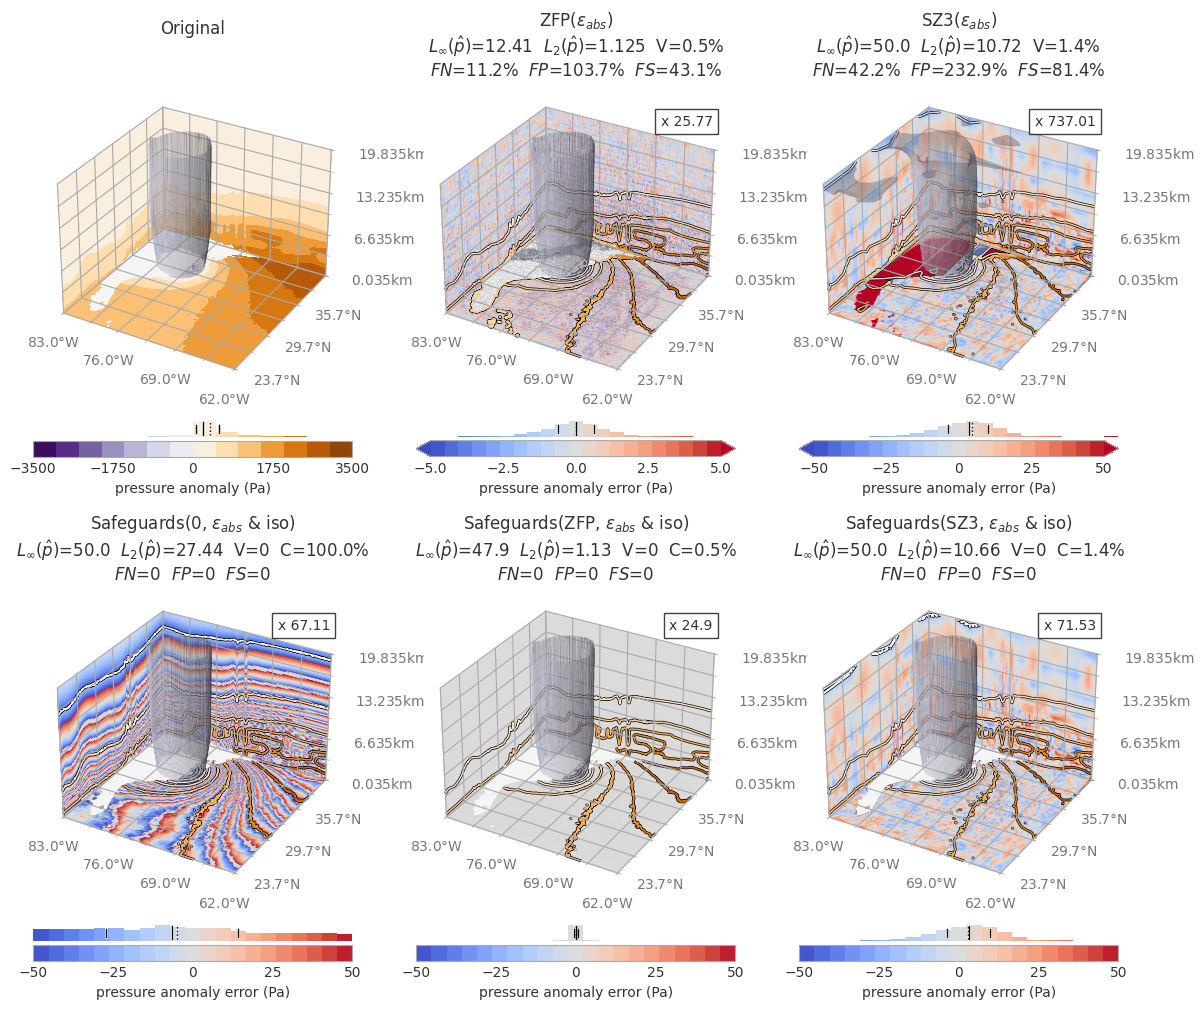

In [13]:
fig = plt.figure(figsize=(14, 12))
gs = gridspec.GridSpec(2, 3)

plot_isosurface(
    pf48,
    pf48,
    1.0,
    fig.add_subplot(gs[0, 0], projection="3d", computed_zorder=False),
    "Original",
    "p",
    "pressure anomaly (Pa)",
    level=level_p,
    my_span=0,
    span=3500,
)
plot_isosurface(
    pf48_zfp,
    pf48,
    pf48_zfp_cr,
    fig.add_subplot(gs[0, 1], projection="3d", computed_zorder=False),
    r"ZFP($\epsilon_{abs}$)",
    "p",
    "pressure anomaly error (Pa)",
    level=level_p,
    my_span=5,
    span=3500,
    error=True,
)
plot_isosurface(
    pf48_sz3,
    pf48,
    pf48_sz3_cr,
    fig.add_subplot(gs[0, 2], projection="3d", computed_zorder=False),
    r"SZ3($\epsilon_{abs}$)",
    "p",
    "pressure anomaly error (Pa)",
    level=level_p,
    my_span=50,
    span=3500,
    error=True,
)

plot_isosurface(
    pf48_sg["zero"],
    pf48,
    pf48_sg_cr["zero"],
    fig.add_subplot(gs[1, 0], projection="3d", computed_zorder=False),
    r"Safeguards(0, $\epsilon_{abs}$ & iso)",
    "p",
    "pressure anomaly error (Pa)",
    level=level_p,
    my_span=eb_abs_p,
    span=3500,
    corr=pf48_zero,
    error=True,
)
plot_isosurface(
    pf48_sg["zfp.rs"],
    pf48,
    pf48_sg_cr["zfp.rs"],
    fig.add_subplot(gs[1, 1], projection="3d", computed_zorder=False),
    r"Safeguards(ZFP, $\epsilon_{abs}$ & iso)",
    "p",
    "pressure anomaly error (Pa)",
    level=level_p,
    my_span=eb_abs_p,
    span=3500,
    corr=pf48_zfp,
    error=True,
)
plot_isosurface(
    pf48_sg["sz3.rs"],
    pf48,
    pf48_sg_cr["sz3.rs"],
    fig.add_subplot(gs[1, 2], projection="3d", computed_zorder=False),
    r"Safeguards(SZ3, $\epsilon_{abs}$ & iso)",
    "p",
    "pressure anomaly error (Pa)",
    level=level_p,
    my_span=eb_abs_p,
    span=3500,
    corr=pf48_sz3,
    error=True,
)

plt.tight_layout()

plt.savefig("isosurface-p.pdf", dpi=300)

plt.show()

## Example 2: `u` wind

### Compressing u with lossy compressors

We configure each compressor with an absolute error bound of 5 m/s and aim to preserve the mean value isosurface. The error bound is chosen to be quite high so that compression artefacts are visually distinguishable.

In [14]:
eb_abs_u = 5
level_u = float(np.nanmean(uf48))

In [15]:
from numcodecs_wasm_zfp import Zfp

zfp = Zfp(mode="fixed-accuracy", tolerance=eb_abs_u, non_finite="allow-unsafe")

uf48_zfp_enc = zfp.encode(uf48)
uf48_zfp = zfp.decode(uf48_zfp_enc)
uf48_zfp_cr = uf48.nbytes / uf48_zfp_enc.nbytes

In [16]:
from numcodecs_wasm_sz3 import Sz3

sz3 = Sz3(eb_mode="abs", eb_abs=eb_abs_u)

uf48_sz3_enc = sz3.encode(uf48)
uf48_sz3 = sz3.decode(uf48_sz3_enc)
uf48_sz3_cr = uf48.nbytes / uf48_sz3_enc.nbytes

In [17]:
from numcodecs_zero import ZeroCodec

zero = ZeroCodec()

uf48_zero_enc = zero.encode(uf48)
uf48_zero = zero.decode(uf48_zero_enc)

### Compressing u using the safeguards-wrapped lossy compressors

We configure the safeguards to bound the pointwise absolute error and preserve the mean `u` wind isosurface by using a `sign` safeguard that is offset by the value of the isosurface.

In [18]:
from numcodecs_safeguards import SafeguardsCodec

uf48_sg = dict()
uf48_sg_cr = dict()

for codec in [
    zero,
    zfp,
    sz3,
]:
    sg = SafeguardsCodec(
        codec=codec,
        safeguards=[
            dict(kind="eb", type="abs", eb=eb_abs_u, equal_nan=True),
            dict(kind="sign", offset=level_u),
        ],
    )

    uf48_sg_enc = sg.encode(uf48)
    uf48_sg[codec.codec_id] = sg.decode(uf48_sg_enc)
    uf48_sg_cr[codec.codec_id] = uf48.nbytes / np.asarray(uf48_sg_enc).nbytes

### Visual comparison of the u wind isosurfaces

/var/folders/8v/swxsmn0d4vz5yzwjhf6bc26x3g7lq6/T/ipykernel_24982/3227524013.py:63: RuntimeWarning: invalid value encountered in subtract
  my_f - f,
/Users/junityre/numcodecs-safeguards/.venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/junityre/numcodecs-safeguards/.venv/lib/python3.10/site-packages/numpy/lib/_shape_base_impl.py:662: RuntimeWarning: invalid value encountered in cast
  return _nx.concatenate(arrays, 1)
/var/folders/8v/swxsmn0d4vz5yzwjhf6bc26x3g7lq6/T/ipykernel_24982/3227524013.py:63: RuntimeWarning: invalid value encountered in subtract
  my_f - f,
/Users/junityre/numcodecs-safeguards/.venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/junityre/numcodecs-safeguards/.venv/lib/python3.10/site-packages/numpy/lib/_shape_base_impl.py:662: RuntimeWarning

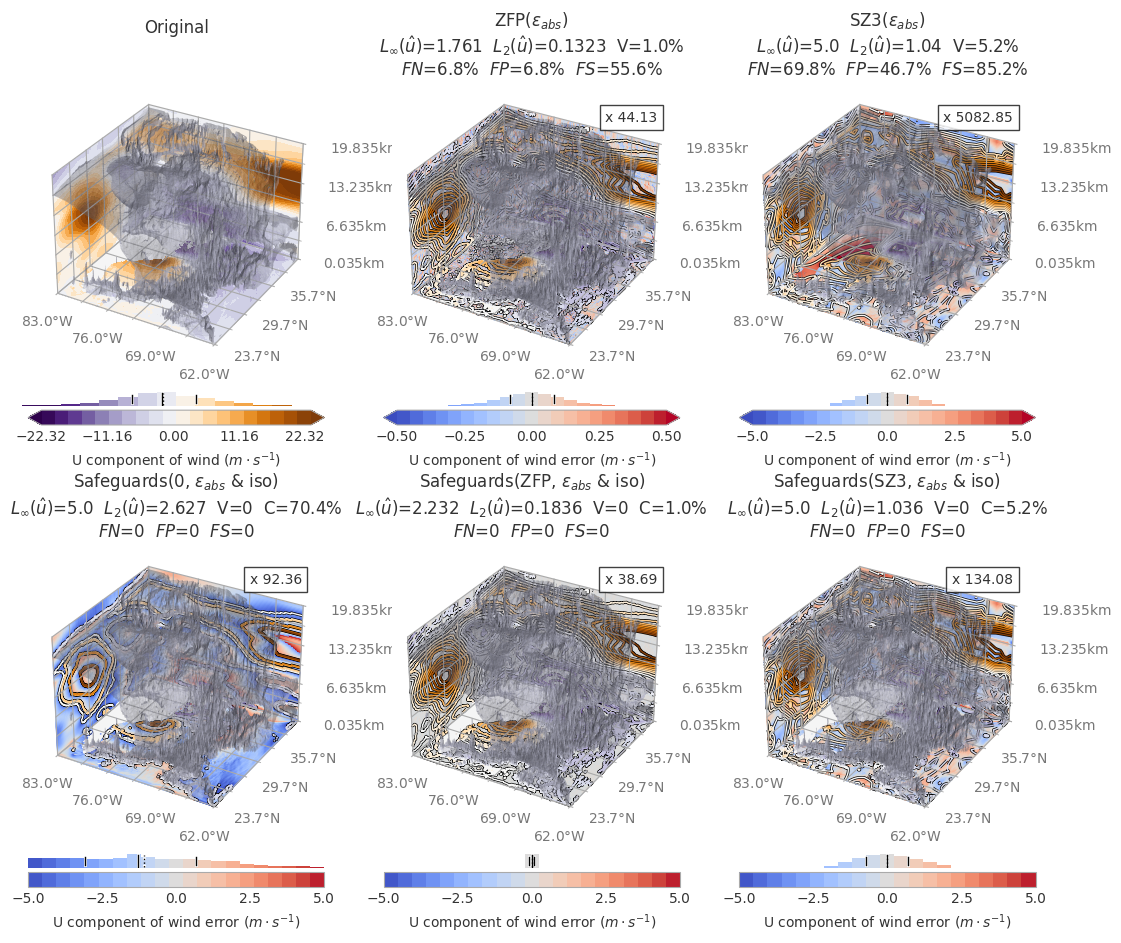

In [20]:
fig = plt.figure(figsize=(13, 11))
gs = gridspec.GridSpec(2, 3)

plot_isosurface(
    uf48,
    uf48,
    1.0,
    fig.add_subplot(gs[0, 0], projection="3d", computed_zorder=False),
    "Original",
    "u",
    r"U component of wind ($m \cdot s^{-1}$)",
    level=level_u,
    my_span=0,
    span=np.abs(level_u) * 10,
    n=21,
)
plot_isosurface(
    uf48_zfp,
    uf48,
    uf48_zfp_cr,
    fig.add_subplot(gs[0, 1], projection="3d", computed_zorder=False),
    r"ZFP($\epsilon_{abs}$)",
    "u",
    r"U component of wind error ($m \cdot s^{-1}$)",
    level=level_u,
    my_span=0.5,
    span=np.abs(level_u) * 10,
    n=21,
    error=True,
)
plot_isosurface(
    uf48_sz3,
    uf48,
    uf48_sz3_cr,
    fig.add_subplot(gs[0, 2], projection="3d", computed_zorder=False),
    r"SZ3($\epsilon_{abs}$)",
    "u",
    r"U component of wind error ($m \cdot s^{-1}$)",
    level=level_u,
    my_span=5,
    span=np.abs(level_u) * 10,
    n=21,
    error=True,
)

plot_isosurface(
    uf48_sg["zero"],
    uf48,
    uf48_sg_cr["zero"],
    fig.add_subplot(gs[1, 0], projection="3d", computed_zorder=False),
    r"Safeguards(0, $\epsilon_{abs}$ & iso)",
    "u",
    r"U component of wind error ($m \cdot s^{-1}$)",
    level=level_u,
    my_span=eb_abs_u,
    span=np.abs(level_u) * 10,
    n=21,
    corr=uf48_zero,
    error=True,
)
plot_isosurface(
    uf48_sg["zfp.rs"],
    uf48,
    uf48_sg_cr["zfp.rs"],
    fig.add_subplot(gs[1, 1], projection="3d", computed_zorder=False),
    r"Safeguards(ZFP, $\epsilon_{abs}$ & iso)",
    "u",
    r"U component of wind error ($m \cdot s^{-1}$)",
    level=level_u,
    my_span=eb_abs_u,
    span=np.abs(level_u) * 10,
    n=21,
    corr=uf48_zfp,
    error=True,
)
plot_isosurface(
    uf48_sg["sz3.rs"],
    uf48,
    uf48_sg_cr["sz3.rs"],
    fig.add_subplot(gs[1, 2], projection="3d", computed_zorder=False),
    r"Safeguards(SZ3, $\epsilon_{abs}$ & iso)",
    "u",
    r"U component of wind error ($m \cdot s^{-1}$)",
    level=level_u,
    my_span=eb_abs_u,
    span=np.abs(level_u) * 10,
    n=21,
    corr=uf48_sz3,
    error=True,
)

plt.tight_layout()

plt.savefig("isosurface-u.pdf", dpi=300)

plt.show()

## Preserving multiple isosurfaces

The safeguards can also preserve an arbitrary number of isosurfaces by using multiple `sign` safeguards with `offsets` that match the isosurface values.

```python
SafeguardsCodec(
    codec=codec,
    safeguards=[
        dict(kind="sign", offset=-10),
        dict(kind="sign", offset=0),
        dict(kind="sign", offset=10),
        ...
    ],
)
```

These offsets can also be late-bound, e.g. `offset="offset"`, to use a pointwise-varying isosurface values.